In [2]:
import numpy as np
import pandas as pd
from IPython.display import display
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
# import tkinter
import matplotlib
%matplotlib inline
# matplotlib.use('TkAgg')



In [3]:
# cc_bb_dir = '/mnt/d/physics/gamma-optical/2001/output/bayesian_block_cc/'
cc_bb_dir = '../../2001/output/bayesian_block_cc/'
cc_dir = '../../2001/output/cross_corr/'
cc_sig_dir = '../../2001/output/cross_object_gam+opt/'

object_arr = np.arange(0,763)

In [3]:
object_arr = np.arange(0,763)

df_arr = []
for oo in range(0,len(object_arr)):
    object_num = object_arr[oo]

    cc_bb_file = cc_bb_dir+'object'+str(object_num).zfill(4)+'_cc_change_points_000.dat'
    
    try:
        read_in_bb = np.loadtxt(cc_bb_file)
#         print('Working on object '+str(object_num))
#         print('bayesian block array shape: '+str(read_in_bb.shape))
    except:
        print("Couldn't read cc_bb file for object "+str(object_num))
        continue
        
    bb_time_index = read_in_bb[0].astype(int)
    bb_bin_norm = read_in_bb[1]
    num_bins = len(bb_time_index)


    bb_bin_start = bb_time_index

    bb_bin_end = np.zeros(len(bb_bin_start)).astype(np.int)
    bb_bin_end[:-1] = bb_time_index[1:]
    bb_bin_end[-1] = 14999

    # print(bb_bin_start)
    # print(bb_bin_end)


    cc_file = cc_dir+'object'+str(object_num).zfill(4)+'_stats000.dat'
    # read_in_cc = np.loadtxt(cc_file)
    # print(read_in_cc.shape)

    cc_sig_file = cc_sig_dir+'cross_object'+str(object_num).zfill(4)+'_all_stats_000.dat'
    # read_in_cc_sig = np.loadtxt(cc_sig_file)
    # print(read_in_cc_sig.shape)



    ## Reading in cross correlation values

    read_in = np.loadtxt(cc_file)

    time_err = read_in[0]
    data_err = read_in[1:]

    cor_mean = data_err[0]
    cor_err_d = cor_mean-data_err[1]
    cor_err_u = data_err[2]-cor_mean

    # expected_cor_up = cor_err_u *np.sqrt(2/np.pi)
    # expected_cor_dn = cor_err_d *np.sqrt(2/np.pi)

    # expected_cor = cor_mean + expected_cor_up - expected_cor_dn

    # cor_mean = expected_cor

    # print('cc array shape: '+str(data_err.shape))

    ## Making significance function

    read_in = np.loadtxt(cc_sig_file)
    time = read_in[0]
    data = read_in[1:] ## significance
    data = data[:-2] ## getting rid of "all"

    cc_significance = np.zeros(len(time))

    significance = np.array([0., -1., 1., -2., 2., -3., 3.])
    for ii in range(0,len(time)):
        significance_function = interp1d(data.T[ii], significance, axis=0, fill_value='extrapolate')
        cc_significance[ii] = significance_function(cor_mean[ii])

    cc_significance[np.isnan(cc_significance)] = 0.
    # print(cc_significance)

    ## Find max significance in bb bin

    avg_sig = np.zeros(num_bins)
    max_sig = np.zeros(num_bins)
    max_cc_index = np.zeros(num_bins).astype(np.int)

    for ii in range(0,num_bins):
        sig_arr = cc_significance[bb_bin_start[ii]:bb_bin_end[ii]+1]
        cc_arr = cor_mean[bb_bin_start[ii]:bb_bin_end[ii]+1]
        index_arr = np.arange(bb_bin_start[ii], bb_bin_end[ii]+1).astype(np.int)
        if np.average(sig_arr) >= 0:
            avg_sig[ii] = np.average(sig_arr)
            max_sig[ii] = np.amax(sig_arr)
            max_cc_index[ii] = index_arr[np.argmax(cc_arr)] 
        else:
            avg_sig[ii] = np.average(sig_arr)
            max_sig[ii] = np.amin(sig_arr)
            max_cc_index[ii] = index_arr[np.argmin(cc_arr)] 

    # print(avg_sig[:10])
    # print(max_sig[:10])
    # print(max_cc_index[:10])


    '''
    Arrays:
    time
    cor_mean
    bb_bin_start, bb_bin_end, bb_bin_norm
    max_sig, max_cc_index

    We want 
    bin_start_time, bin_end_time, max_cc_in_bin_time, max_cc_in_bin, max_sig_in_bin
    for only sig >= +(-) 2 for local max(min)
    '''

    output_arr = np.zeros([1,5])
    for ii in range(1,num_bins-1):
        if time[bb_bin_end[ii]] < -1500. or time[bb_bin_start[ii]] > 2500.:
            continue

        if bb_bin_norm[ii] >= 0:
            if bb_bin_norm[ii] > bb_bin_norm[ii+1] and bb_bin_norm[ii] > bb_bin_norm[ii-1]:
                bin_start_time = time[bb_bin_start[ii]]
                bin_end_time = time[bb_bin_end[ii]]
                max_cc_in_bin_time = time[max_cc_index[ii]]
                max_cc_in_bin = cor_mean[max_cc_index[ii]]
                max_sig_in_bin = max_sig[ii]
                avg_sig_in_bin = avg_sig[ii]

                if avg_sig_in_bin >= 2.:
                    new_row = np.array([bin_start_time, bin_end_time, max_cc_in_bin_time, max_cc_in_bin, max_sig_in_bin])
                    output_arr = np.append(output_arr, [new_row], axis=0)

        elif bb_bin_norm[ii] < 0:
            if bb_bin_norm[ii] < bb_bin_norm[ii+1] and bb_bin_norm[ii] < bb_bin_norm[ii-1]:
                bin_start_time = time[bb_bin_start[ii]]
                bin_end_time = time[bb_bin_end[ii]]
                max_cc_in_bin_time = time[max_cc_index[ii]]
                max_cc_in_bin = cor_mean[max_cc_index[ii]]
                max_sig_in_bin = max_sig[ii]
                avg_sig_in_bin = avg_sig[ii]

                if avg_sig_in_bin <= -2.:
                    new_row = np.array([bin_start_time, bin_end_time, max_cc_in_bin_time, max_cc_in_bin, max_sig_in_bin])
                    output_arr = np.append(output_arr, [new_row], axis=0)

    if len(output_arr) > 1:
        output_arr = output_arr[1:]
    else:
        continue

    num_sig_bins = len(output_arr)
    output_arr = np.append(object_num*np.ones([num_sig_bins,1]), output_arr, axis = 1)
    
    if len(df_arr) == 0:
        df_arr = output_arr.T
    else:
        df_arr = np.append(df_arr, output_arr.T, axis=1)
    # print(len(output_arr))
    # print(output_arr)


C:\Users\psyko\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Couldn't read cc_bb file for object 117
Couldn't read cc_bb file for object 123
Couldn't read cc_bb file for object 154
Couldn't read cc_bb file for object 295
Couldn't read cc_bb file for object 300
Couldn't read cc_bb file for object 354
Couldn't read cc_bb file for object 375
Couldn't read cc_bb file for object 422
Couldn't read cc_bb file for object 434
Couldn't read cc_bb file for object 469
Couldn't read cc_bb file for object 476
Couldn't read cc_bb file for object 492
Couldn't read cc_bb file for object 523
Couldn't read cc_bb file for object 566
Couldn't read cc_bb file for object 569
Couldn't read cc_bb file for object 641
Couldn't read cc_bb file for object 684
Couldn't read cc_bb file for object 700
Couldn't read cc_bb file for object 707
Couldn't read cc_bb file for object 719
Couldn't read cc_bb file for object 726
Couldn't read cc_bb file for object 761


In [13]:
'''
Convert data to pandas data frame
'''
df_dict = {'object_num':df_arr[0].astype(np.int), 
           'max_cc_time':df_arr[3], 
           'time_start':df_arr[1], 
           'time_end':df_arr[2], 
           'max_cc_val':df_arr[4], 
           'max_sig':df_arr[5]}

df = pd.DataFrame(df_dict)
# df = df.sort_values(by=['object_num', 'max_cc_val'], ascending=[True,False])


df['time_diff'] = df['time_end'] - df['time_start']
df = df.round({'time_start':1, 'time_end':1, 'max_cc_time':1, 'max_cc_val':5, 'max_sig':5, 'time_diff':1})

# print(df.to_markdown)
display(df)
display(df.loc[df['object_num'] == 121])

outfilename = 'cc_sig_data.csv'
df.to_csv(outfilename, index=None)

,object_num,max_cc_time,time_start,time_end,max_cc_val,max_sig,time_diff
0,0,-1379.2,-1382.8,-1371.2,-0.46015,-2.53624,11.6
1,0,-453.2,-470.4,-427.2,0.45101,2.34037,43.2
2,0,-0.4,-5.6,11.2,0.62529,3.86681,16.8
3,0,903.6,876.0,908.8,-0.44024,-2.27980,32.8
4,0,1045.6,1017.6,1059.2,-0.50092,-2.80694,41.6
...,...,...,...,...,...,...,...
497,665,617.2,580.0,669.6,-0.27146,-2.17870,89.6
498,667,15.6,-4.8,75.6,0.29712,2.56851,80.4
499,667,865.2,825.6,900.0,-0.31544,-2.29923,74.4
500,697,-19.2,-56.8,38.4,0.37115,2.56214,95.2


,object_num,max_cc_time,time_start,time_end,max_cc_val,max_sig,time_diff
300,121,-902.0,-915.2,-870.0,0.63997,2.66528,45.2
301,121,-468.8,-495.2,-457.2,-0.44192,-2.38960,38.0
302,121,-30.0,-47.6,-14.0,0.51535,3.10092,33.6


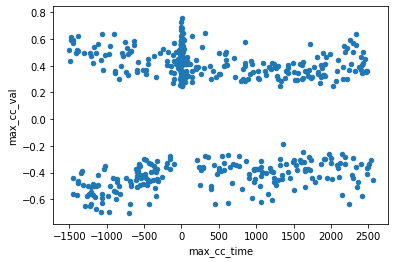

In [5]:
df.plot('max_cc_time', 'max_cc_val', kind='scatter')

In [15]:
'''
Looking for "worthwhile" cc
'''
df['worthwhile'] = 0

choose_sig_cc_time = np.zeros([len(object_arr),3])

choose_sig_cc_time[0,0] = -0.4
choose_sig_cc_time[1,0] = -2.4
choose_sig_cc_time[2,0] = -0.4
choose_sig_cc_time[3,:3] = [-2.4, 198.8, 608.0]
choose_sig_cc_time[4,:3] = [-0.4, -96.4, 956.4]
choose_sig_cc_time[5,:3] = [-3.6, 1518.4, 0]
choose_sig_cc_time[6,:3] = [0.8, 70.8, 222.4]
choose_sig_cc_time[7,:3] = [0.8, 1592.4, 0]
choose_sig_cc_time[8,:3] = [-1.2, 0, 0]
choose_sig_cc_time[9,:3] = [25.2, 0, 0]
choose_sig_cc_time[10,:3] = [-0.4, 0, 0]
choose_sig_cc_time[11,:3] = [73.6, 0, 0]
choose_sig_cc_time[12,:3] = [51.6, 0, 0]
choose_sig_cc_time[13,:3] = [0.4, 0, 0]
choose_sig_cc_time[14,:3] = [-0.4, 0, 0]
choose_sig_cc_time[17,:3] = [18.0, 0, 0]
choose_sig_cc_time[18,:3] = [-3.2, 0, 0]
choose_sig_cc_time[21,:3] = [-975.2, 0, 0]
choose_sig_cc_time[22,:3] = [590., 1724.8, 2215.2]
choose_sig_cc_time[23,:3] = [140., 0, 0]
choose_sig_cc_time[24,:3] = [6.4, 0, 0]
choose_sig_cc_time[28,:3] = [4.8, 0, 0]
choose_sig_cc_time[29,:3] = [2.0, 0, 0]
choose_sig_cc_time[30,:3] = [2428.0, 0, 0]
choose_sig_cc_time[31,:3] = [41.6, -952.0, 0]
choose_sig_cc_time[34,:3] = [-0.4, 0, 0]
choose_sig_cc_time[35,:3] = [27.6, 322.0, 0]
choose_sig_cc_time[37,:3] = [-0.4, 57.2, -632.4]
choose_sig_cc_time[38,:3] = [-2.0, 0, 0]
choose_sig_cc_time[39,:3] = [-2.4, 498.4, 0]
choose_sig_cc_time[40,:3] = [-4.4, 0, 0]
choose_sig_cc_time[42,:3] = [1.6, 0, 0]
choose_sig_cc_time[45,:3] = [-3.2, 0, 0]
choose_sig_cc_time[46,:3] = [-12.4, 0, 0]
choose_sig_cc_time[48,:3] = [2288.8, 0, 0]
choose_sig_cc_time[49,:3] = [9.6, 0, 0]
choose_sig_cc_time[50,:3] = [51.6, 136.4, 0]
choose_sig_cc_time[52,:3] = [-3.2, 0, 0]
choose_sig_cc_time[53,:3] = [1925.6, 1728.8, 0]
choose_sig_cc_time[54,:3] = [-2.8, -146.0, 0]
choose_sig_cc_time[57,:3] = [8.4, 0, 0]
choose_sig_cc_time[59,:3] = [-0.4, 0, 0]
choose_sig_cc_time[61,:3] = [939.6, 0, 0]
choose_sig_cc_time[63,:3] = [-192.8, 0, 0]
choose_sig_cc_time[65,:3] = [2.0, 0, 0]
choose_sig_cc_time[66,:3] = [11.6, 1178.0, 0]
choose_sig_cc_time[70,:3] = [-0.8, 0, 0]
choose_sig_cc_time[71,:3] = [-1.6, 2261.2, 600.4]
choose_sig_cc_time[77,:3] = [-4.0, 0, 0]
choose_sig_cc_time[78,:3] = [-469.6, 0, 0]
choose_sig_cc_time[80,:3] = [-1176.4, 0, 0]
choose_sig_cc_time[84,:3] = [-4.4, 0, 0]
choose_sig_cc_time[85,:3] = [-4.0, 1807.6, 0]
choose_sig_cc_time[86,:3] = [2.4, 456.8, -1059.2]
choose_sig_cc_time[87,:3] = [4.0, 1405.2, 0]
choose_sig_cc_time[92,:3] = [521.2, 0, 0]
choose_sig_cc_time[95,:3] = [416.4, 2097.6, 0]
choose_sig_cc_time[100,:3] = [-3.6, 0, 0]
choose_sig_cc_time[101,:3] = [-96.4, -0.8, 0]
choose_sig_cc_time[103,:3] = [2.4, 0, 0]
choose_sig_cc_time[106,:3] = [-579.6, 1707.2, 0]
choose_sig_cc_time[107,:3] = [0.0, -1, -1]
choose_sig_cc_time[109,:3] = [1319.2, 0, 0]
choose_sig_cc_time[113,:3] = [7.2, 0, 0]
choose_sig_cc_time[116,:3] = [-6.0, 0, 0]
choose_sig_cc_time[121,:3] = [-30.0, 0, 0]
choose_sig_cc_time[122,:3] = [1915.2, 2272.8, 0]
choose_sig_cc_time[124,:3] = [-4.4, 1746.0, 0]
choose_sig_cc_time[127,:3] = [1240.8, 1619.2, 1769.6]
choose_sig_cc_time[128,:3] = [2300.4, 0, 0]
choose_sig_cc_time[129,:3] = [27.6, 598.4, 0]
choose_sig_cc_time[130,:3] = [2.4, 0, 0]
choose_sig_cc_time[131,:3] = [6.4, 574.0, 0]
choose_sig_cc_time[134,:3] = [-2.4, 0, 0]
choose_sig_cc_time[139,:3] = [-1.2, 1021.6, 2239.6]
choose_sig_cc_time[140,:3] = [6.0, 0, 0]
choose_sig_cc_time[141,:3] = [-140.4, 0, 0]
choose_sig_cc_time[152,:3] = [-15.2, 1561.2, 0]
choose_sig_cc_time[156,:3] = [1826.0, 0, 0]
choose_sig_cc_time[157,:3] = [-11.2, 0, 0]
choose_sig_cc_time[158,:3] = [-282.0, 0, 0]
choose_sig_cc_time[160,:3] = [40.8, 0, 0]
choose_sig_cc_time[165,:3] = [1610.8, 0, 0]
choose_sig_cc_time[166,:3] = [-187.6, 1891.2, 0]
choose_sig_cc_time[168,:3] = [-2.8, 0, 0]
choose_sig_cc_time[173,:3] = [-2.4, -1143.2, 0]
choose_sig_cc_time[174,:3] = [36.8, 2341.6, 0]
choose_sig_cc_time[175,:3] = [28.0, 0, 0]
choose_sig_cc_time[176,:3] = [8.4, 0, 0]
choose_sig_cc_time[187,:3] = [-0.4, 0, 0]
choose_sig_cc_time[189,:3] = [1026.4, 0, 0]
choose_sig_cc_time[195,:3] = [2024.4, 0, 0]
choose_sig_cc_time[197,:3] = [-0.8, 1868.8, 0]
choose_sig_cc_time[206,:3] = [1.2, 0, 0]
choose_sig_cc_time[209,:3] = [-2.0, 0, 0]
choose_sig_cc_time[219,:3] = [-3.6, 0, 0]
choose_sig_cc_time[220,:3] = [4.0, 138.8, 0]
choose_sig_cc_time[226,:3] = [-96.8, 0, 0]
choose_sig_cc_time[231,:3] = [4.8, 0, 0]
choose_sig_cc_time[243,:3] = [1.2, 817.6, 0]
choose_sig_cc_time[248,:3] = [22.4, -1082.4, 0]
choose_sig_cc_time[258,:3] = [66.4, 0, 0]
choose_sig_cc_time[259,:3] = [-0.4, 1218.4, 0]
choose_sig_cc_time[261,:3] = [0.8, 0, 0]
choose_sig_cc_time[270,:3] = [-51.6, 0, 0]
choose_sig_cc_time[272,:3] = [144.8, 0, 0]
choose_sig_cc_time[276,:3] = [-64.0, 920.4, 0]
choose_sig_cc_time[284,:3] = [4.8, 0, 0]
choose_sig_cc_time[290,:3] = [0.8, 0, 0]
choose_sig_cc_time[291,:3] = [67.6, 0, 0]
choose_sig_cc_time[294,:3] = [8.0, 0, 0]
choose_sig_cc_time[308,:3] = [-1016.0, 0, 0]
choose_sig_cc_time[309,:3] = [2378.4, 0, 0]
choose_sig_cc_time[317,:3] = [81.2, -174.4, 0]
choose_sig_cc_time[329,:3] = [-16.8, 0, 0]
choose_sig_cc_time[330,:3] = [13.2, 0, 0]
choose_sig_cc_time[331,:3] = [-22.8, 0, 0]
choose_sig_cc_time[337,:3] = [-50.8, 0, 0]
choose_sig_cc_time[339,:3] = [4.0, 0, 0]
choose_sig_cc_time[358,:3] = [-16.0, 0, 0]
choose_sig_cc_time[361,:3] = [9.6, 114.4, 0]
choose_sig_cc_time[363,:3] = [37.6, 0, 0]
choose_sig_cc_time[364,:3] = [-882.8, 0, 0]
choose_sig_cc_time[386,:3] = [2.8, 0, 0]
choose_sig_cc_time[406,:3] = [0.4, 0, 0]
choose_sig_cc_time[409,:3] = [22.4, 496.8, 0]
choose_sig_cc_time[416,:3] = [1847.2, 0, 0]
choose_sig_cc_time[418,:3] = [-9.2, 0, 0]
choose_sig_cc_time[420,:3] = [1656.4, 0, 0]
choose_sig_cc_time[421,:3] = [8.8, 0, 0]
choose_sig_cc_time[428,:3] = [-0.8, 0, 0]
choose_sig_cc_time[433,:3] = [-1.2, 0, 0]
choose_sig_cc_time[448,:3] = [1.6, 0, 0]
choose_sig_cc_time[458,:3] = [-12.4, 0, 0]
choose_sig_cc_time[467,:3] = [1043.2, 0, 0]
choose_sig_cc_time[472,:3] = [-737.6, 0, 0]
choose_sig_cc_time[478,:3] = [-96.4, 0, 0]
choose_sig_cc_time[489,:3] = [261.2, 2074.8, 0]
choose_sig_cc_time[512,:3] = [85.2, 0, 0]
choose_sig_cc_time[551,:3] = [38.8, -776.4, 931.2]
choose_sig_cc_time[563,:3] = [-108.8, 0, 0]
choose_sig_cc_time[564,:3] = [278.4, 0, 0]
choose_sig_cc_time[629,:3] = [46.8, -805.6, 0]
choose_sig_cc_time[642,:3] = [-72.8, 0, 0]
choose_sig_cc_time[665,:3] = [-7.6, 0, 0]
choose_sig_cc_time[667,:3] = [15.6, 0, 0]
choose_sig_cc_time[697,:3] = [-19.2, 0, 0]

object_look = 128

for oo in range(0,len(object_arr)):
    object_num = object_arr[oo]

    choose_sig = df['max_cc_time'] == choose_sig_cc_time[oo,0]
    for ii in range(1,3):
        choose_sig_temp = df['max_cc_time'] == choose_sig_cc_time[oo,ii]
        choose_sig = np.logical_or(choose_sig, choose_sig_temp)
    choose_sig = np.logical_and(choose_sig, df['object_num'] == object_num)
    
    df.loc[choose_sig, 'worthwhile' ] = 1

# df.loc[np.logical_and(df['object_num'] == 0, df['max_cc_time'] == -0.4), 'worthwhile' ] = 1
display(df.loc[df['object_num']==object_look])

df_worthwhile = df.loc[df['worthwhile']==1]
df_worthwhile = df_worthwhile.round({'max_cc_time':1, 'time_start':1, 'time_end':1, 'max_cc_val':3, 'max_sig':2})


# df_worthwhile_out = df_worthwhile[['object_num','max_cc_time']]
# df_worthwhile_out['cc_time_up'] = df_worthwhile['time_end'] - df_worthwhile['max_cc_time']
# df_worthwhile_out['cc_time_dn'] = df_worthwhile['max_cc_time'] - df_worthwhile['time_start'] 
# df_worthwhile_out[['max_cc_val', 'max_sig']] = df_worthwhile[['max_cc_val', 'max_sig']] 

# df_worthwhile_out = df_worthwhile_out.round({'max_cc_time':1, 'cc_time_up':1, 'cc_time_dn':1, 'max_cc_val':3, 'max_sig':2})


# # df_worthwhile = df_worthwhile.drop(columns=['worthwhile','time_diff'])
outfilename = 'cc_sig_data+worthwhile.csv'
df_worthwhile.to_csv(outfilename, index=None)

,object_num,max_cc_time,time_start,time_end,max_cc_val,max_sig,time_diff,worthwhile
313,128,2174.0,2134.4,2188.8,0.54921,2.81591,54.4,0
314,128,2300.4,2266.0,2317.2,0.56778,3.02439,51.2,1


In [11]:
'''
Create LATEX table
'''
df = pd.read_csv('cc_sig_data.csv')
df_worthwhile = pd.read_csv('cc_sig_data+worthwhile.csv')
df_worthwhile = df_worthwhile.round({'max_sig':2, 'max_cc_val':2})

display(df_worthwhile)

dfw = df_worthwhile
dfw = dfw.sort_values(by=['object_num', 'max_sig'], ascending=[True,False])

out_table = open('latex_table.txt', 'w')
out_table.write('\\begin{tabular}{ c @{\hskip 1em} c rcl @{\hskip 1em} c @{\hskip 1em} c @{\hskip 1em} c }  \n')
out_table.write('\\toprule \n')
# out_table.write('Object \# & & & & & & & $\\tau_{\\mathrm{max}}$ & CC val & CC sig \\\ \n')
out_table.write('Object \# & & \multicolumn{3}{c}{Range} & $\\tau_{\\mathrm{max}}$ & $r_S$ & CC sig \\\ \n')
out_table.write('\\midrule \n')

for oo in range(0,len(object_arr)):
    object_num = object_arr[oo]
    df_obj = dfw.loc[df['object_num'] == object_num]
#     display(df_obj)
    if len(df_obj) > 0:
        out_table.write(str(object_num))
        
        for ii in range(0,len(df_obj)):
            out_table.write(' & ')
            if df_obj['time_start'].values[ii] <= 0 and df_obj['time_end'].values[ii] >= 0 :
                out_table.write('$\\bullet$ & ')
            else:
                out_table.write('& ')
#           if df_obj['time_start'].values[ii] <= 0 and df_obj['time_end'].values[ii] >= 0 :
#                 out_table.write('\\bf{[}& \\bf{'+str(df_obj['time_start'].values[ii])+'}& \\bf{,} &\\bf{'+str(df_obj['time_end'].values[ii])+'}&\\bf{]} & ')
#             else:
            out_table.write(str(df_obj['time_start'].values[ii])+' & $\\rightleftharpoons$ & '+str(df_obj['time_end'].values[ii])+' & ')
            out_table.write(str(df_obj['max_cc_time'].values[ii])+' & ')
            out_table.write(str(df_obj['max_cc_val'].values[ii])+' & ')
            
            if df_obj['max_sig'].values[ii] >= 3.0:
                out_table.write('\\bf{'+str(df_obj['max_sig'].values[ii])+'}')
            else:
                out_table.write(str(df_obj['max_sig'].values[ii]))
            
            if oo < len(object_arr) -1:
                out_table.write(' \\\ \n')
            else:
                out_table.write(' \n')

        
out_table.write('\\end{tabular} \n')

out_table.close()



,object_num,max_cc_time,time_start,time_end,max_cc_val,max_sig,time_diff,worthwhile
0,0,-0.4,-5.6,11.2,0.62,3.87,16.8,1
1,1,-2.4,-7.6,4.0,0.56,4.34,11.6,1
2,2,-0.4,-4.8,13.6,0.41,3.22,18.4,1
3,3,-2.4,-14.8,12.4,0.48,2.54,27.2,1
4,3,198.8,177.2,212.4,0.44,2.38,35.2,1
...,...,...,...,...,...,...,...,...
195,629,46.8,30.4,64.8,0.30,2.42,34.4,1
196,642,-72.8,-96.4,4.4,0.51,2.86,100.8,1
197,665,-7.6,-40.4,30.4,0.40,3.19,70.8,1
198,667,15.6,-4.8,75.6,0.30,2.57,80.4,1


In [17]:
'''
Create LATEX table TWO ROWS
'''

dfw = df_worthwhile

dfw = dfw.sort_values(by=['object_num', 'max_sig'], ascending=[True,False])

display(dfw)

num_rows = len(dfw)
max_row_per_column = 50
number_of_columns = int(np.ceil(num_rows/max_row_per_column))
print(number_of_columns)

# num_rows_col1 = int(np.ceil(num_rows/2.))
# num_rows_col2 = int(np.floor(num_rows/2.))
# print(num_rows, num_rows_col1, num_rows_col2)

out_table = open('latex_table_two_column.txt', 'w')

header = '\\begin{tabular}{ c l @{\hskip 2em} r c l @{\hskip 2em} c @{\hskip 1em} c @{\hskip 1em} c } \n'
header+= '\\toprule \n'
header+= 'Object \# & \multicolumn{4}{c}{ \ \ \ Range} & $\\tau_{\\mathrm{max}}$ & $r_S$ & CC sig \\\ \n'
header+= '\\midrule \n'

out_table.write(header)

# out_table.write('\\begin{tabular}{ c @{\hskip 1em} c rcl @{\hskip 1em} c @{\hskip 1em} c @{\hskip 1em} c }  \n')
# out_table.write('\\toprule \n')
# # out_table.write('Object \# & & & & & & & $\\tau_{\\mathrm{max}}$ & CC val & CC sig \\\ \n')
# out_table.write('Object \# & & \multicolumn{3}{c}{Range} & $\\tau_{\\mathrm{max}}$ & $r_S$ & CC sig \\\ \n')
# out_table.write('\\midrule \n')

row_num = 0
col_num = 0
# col_tag = np.zeros([2]).astype(np.int)
# print(len(object_arr))

for oo in range(0,len(object_arr)):
	object_num = object_arr[oo]
	
	df_obj = dfw.loc[dfw['object_num'] == object_num]
# 	print(object_num, len(df_obj))
	if len(df_obj) > 0:
		out_table.write(str(object_num)) ## List object_num once
		
		for ii in range(0,len(df_obj)): ## Go through all sig CC
			out_table.write(' & ')
			
			## Put a symbol if CC consistent with t=0
			if df_obj['time_start'].values[ii] <= 0 and df_obj['time_end'].values[ii] >= 0 :
				out_table.write('$\\circ$ & ')
			else:
				out_table.write('& ')
			
			## List CC values
			out_table.write(str(df_obj['time_start'].values[ii])+' & $\\cdot$ & '+str(df_obj['time_end'].values[ii])+' & ')
			out_table.write(str(df_obj['max_cc_time'].values[ii])+' & ')
			out_table.write(str(df_obj['max_cc_val'].values[ii])+' & ')
			
			## Final column: if >3 sigma, make bold
			if df_obj['max_sig'].values[ii] >= 3.0:
				out_table.write('\\bf{'+str(df_obj['max_sig'].values[ii])+'}')
			else:
				out_table.write(str(df_obj['max_sig'].values[ii]))
			
			row_num+= 1 ## FINISHED ROW
			
			## What to do at end of row
			if row_num >= max_row_per_column and col_num%2 == 0:
				out_table.write(' \n')
				out_table.write('\\end{tabular} \n')
				out_table.write('\\hspace{1cm} \n')
				out_table.write(header)
				
				col_num+= 1
				row_num = 0
			elif row_num >= max_row_per_column and col_num%2 == 1:
				out_table.write(' \n')
				out_table.write('\\end{tabular} \n')
				out_table.write('\n\n\n\n')
				
				out_table.write(header)
				
				col_num+= 1
				row_num = 0
				
			else:
				out_table.write(' \\\ \n')
			
while row_num < max_row_per_column:
	out_table.write(' \\\ \n')
	row_num+= 1
out_table.write('\\end{tabular} \n')

out_table.close()



,object_num,max_cc_time,time_start,time_end,max_cc_val,max_sig,time_diff,worthwhile
0,0,-0.4,-5.6,11.2,0.62,3.87,16.8,1
1,1,-2.4,-7.6,4.0,0.56,4.34,11.6,1
2,2,-0.4,-4.8,13.6,0.41,3.22,18.4,1
3,3,-2.4,-14.8,12.4,0.48,2.54,27.2,1
4,3,198.8,177.2,212.4,0.44,2.38,35.2,1
...,...,...,...,...,...,...,...,...
194,629,-805.6,-838.4,-778.0,0.40,2.40,60.4,1
196,642,-72.8,-96.4,4.4,0.51,2.86,100.8,1
197,665,-7.6,-40.4,30.4,0.40,3.19,70.8,1
198,667,15.6,-4.8,75.6,0.30,2.57,80.4,1


4


In [18]:
o_num = dfw['object_num'].loc[dfw].values
blah = np.unique(o_num)
print(blah)
print(len(blah))

ValueError: Cannot index with multidimensional key

In [22]:
arr1 = dfw['max_sig'] >= 4.
arr2 = dfw['max_sig'] >= 4

arr = np.logical_and(arr1,arr2)
dfw2 = dfw.loc[arr]

o_num = dfw2['object_num'].values
blah = np.unique(o_num)
print('Object numbers:'+str(blah))
print('# objects with sig CC:  '+str(len(blah)))

# arr = dfw.index[]
arr1 = dfw2['time_start']<0
arr2 = dfw2['time_end']>0
arr = np.logical_and(arr1, arr2)
print('# objects with consistent w/0:  '+str(np.sum(arr)))

Object numbers:[  1   6   8   9  28  65  86 107 219 294]
# objects with sig CC:  10
# objects with consistent w/0:  9
